In [1]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import shap
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import joblib

import warnings
warnings.filterwarnings("ignore")




sns.set(style="whitegrid")


In [2]:
day_df = pd.read_csv(r"D:\project\PRCP-1018-BikeRental (1)-to work\Data\day.csv")
hour_df = pd.read_csv(r"D:\project\PRCP-1018-BikeRental (1)-to work\Data\hour.csv")

datasets = {'Day': day_df, 'Hour': hour_df}

# Convert date column
for name, df in datasets.items():
    df['dteday'] = pd.to_datetime(df['dteday'])
    print(f"{name} info:")
    print(df.info())
    print(df.isnull().sum())
    print(df.duplicated().sum(), "\n")

# Day dataset
cat_cols_day = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

# Hour dataset
cat_cols_hour = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']

num_cols=['temp','atemp','hum', 'windspeed']



Day info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns

In [3]:
# Day
for col in cat_cols_day:
    day_df[col] = day_df[col].astype('category')

# Hour
for col in cat_cols_hour:
    hour_df[col] = hour_df[col].astype('category')

day_df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    category      
 3   yr          731 non-null    category      
 4   mnth        731 non-null    category      
 5   holiday     731 non-null    category      
 6   weekday     731 non-null    category      
 7   workingday  731 non-null    category      
 8   weathersit  731 non-null    category      
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: category(7), datetime64

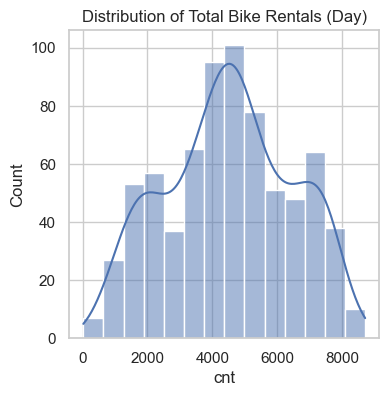

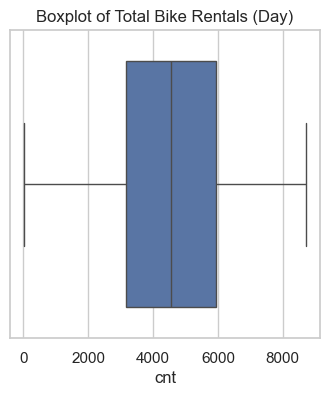

Day cnt skewness: -0.05
Day cnt kurtosis: -0.81
Day outliers in cnt: 0



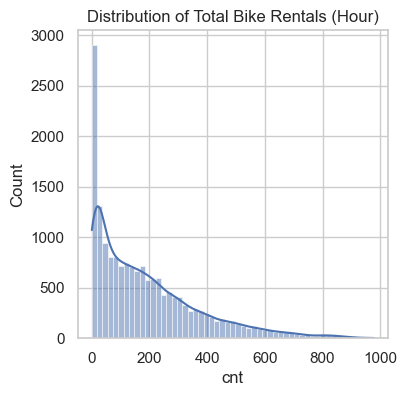

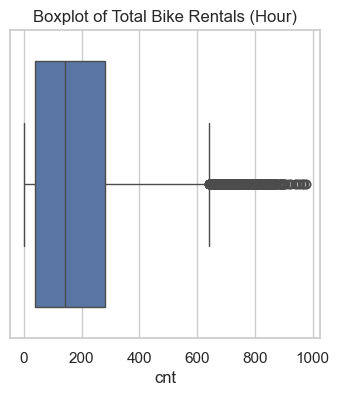

Hour cnt skewness: 1.28
Hour cnt kurtosis: 1.42
Hour outliers in cnt: 505



In [4]:
def target_analysis(df, dataset_name):
    # Histogram 
    plt.figure(figsize=(4,4))
    sns.histplot(df['cnt'], kde=True)
    plt.title(f'Distribution of Total Bike Rentals ({dataset_name})')
    plt.xlabel('cnt')
    plt.show()
    
    # Boxplot
    plt.figure(figsize=(4,4))
    sns.boxplot(x=df['cnt'])
    plt.title(f'Boxplot of Total Bike Rentals ({dataset_name})')
    plt.show()
    
    # Skewness & Kurtosis
    skew = df['cnt'].skew()
    kurt = df['cnt'].kurtosis()
    print(f"{dataset_name} cnt skewness: {skew:.2f}")
    print(f"{dataset_name} cnt kurtosis: {kurt:.2f}")
    
    #Outliers using IQR
    Q1 = df['cnt'].quantile(0.25)
    Q3 = df['cnt'].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    outliers = ((df['cnt'] < lower_limit) | (df['cnt'] > upper_limit)).sum()
    print(f"{dataset_name} outliers in cnt: {outliers}\n")


target_analysis(day_df, 'Day')
target_analysis(hour_df, 'Hour')


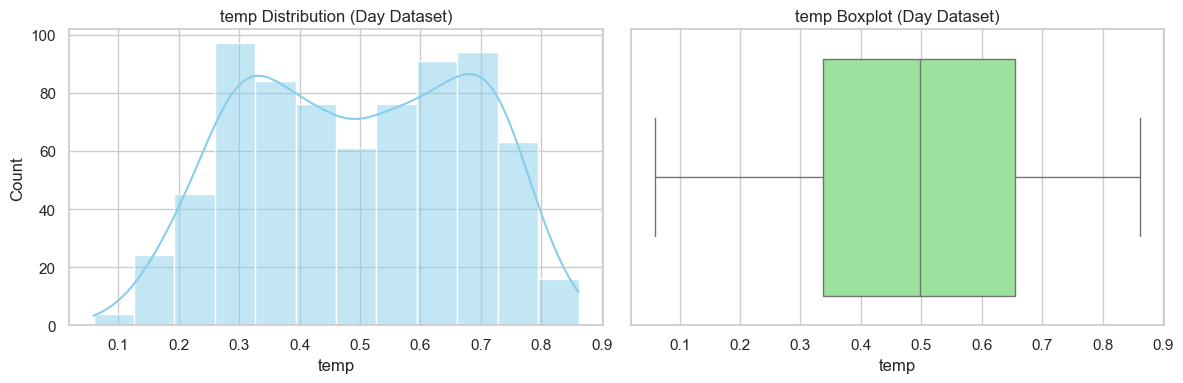

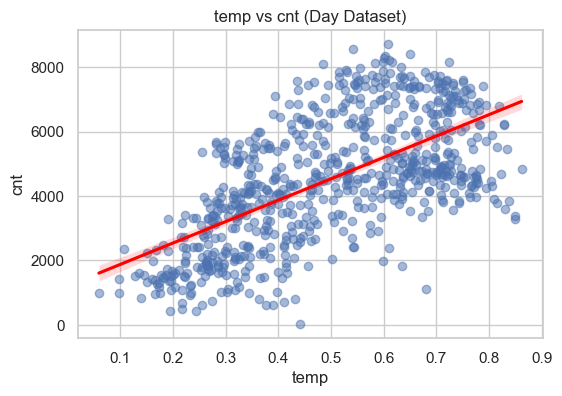

Day Dataset - Correlation of temp with cnt: 0.63



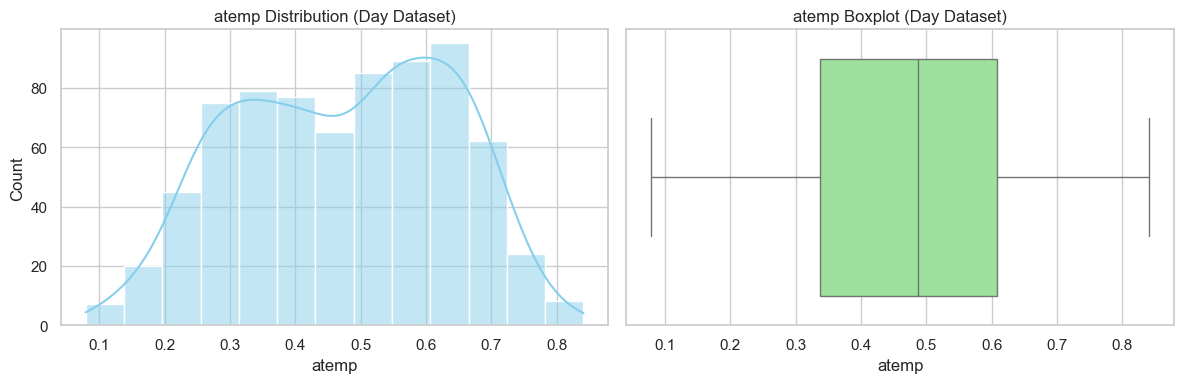

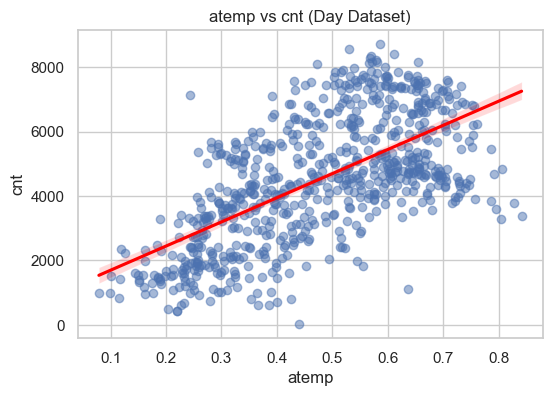

Day Dataset - Correlation of atemp with cnt: 0.63



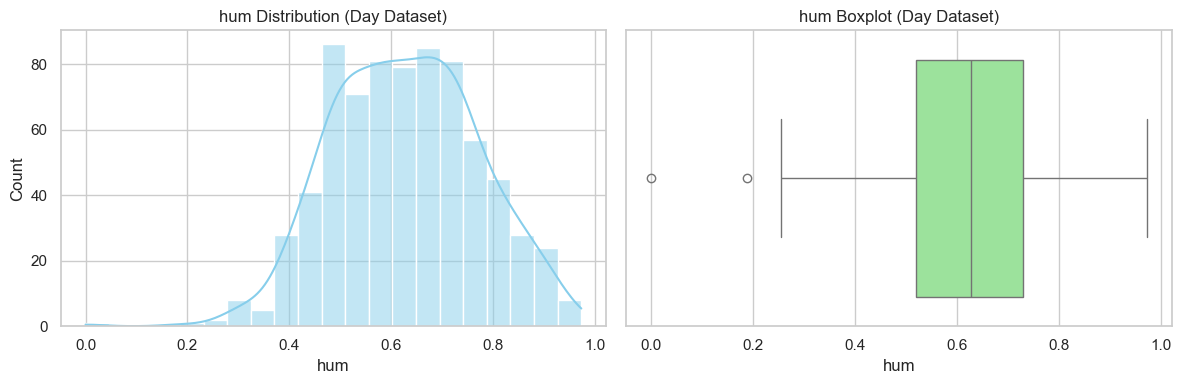

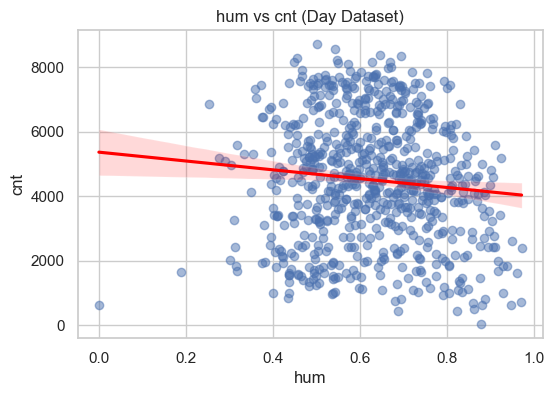

Day Dataset - Correlation of hum with cnt: -0.10



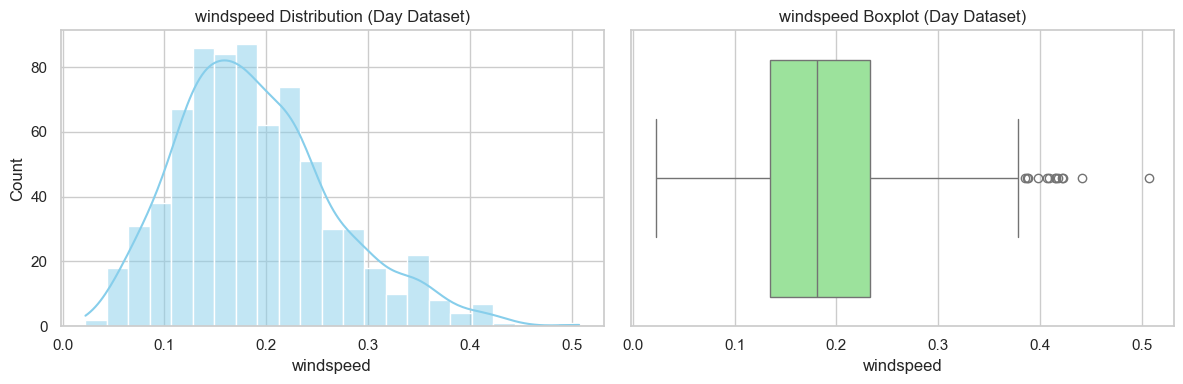

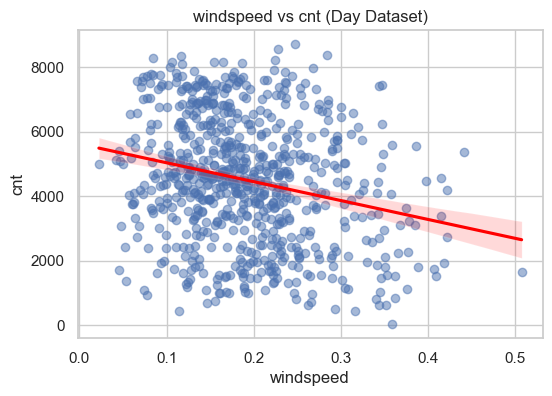

Day Dataset - Correlation of windspeed with cnt: -0.23



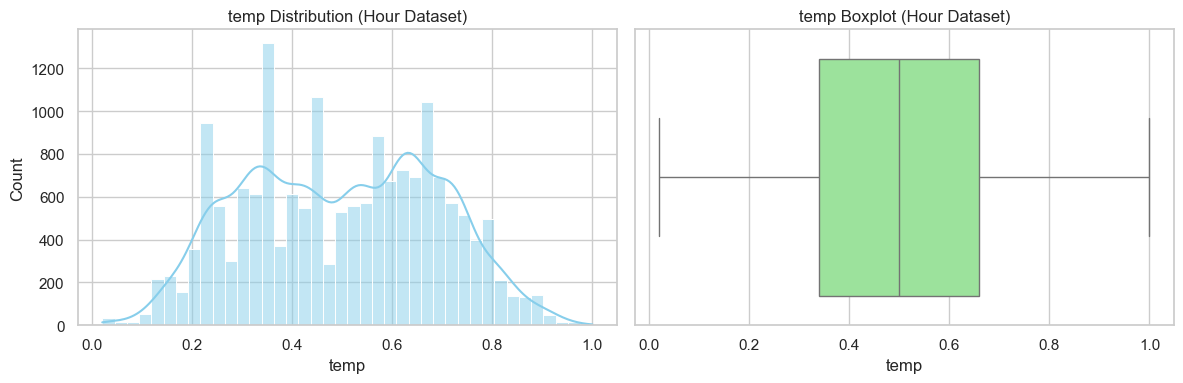

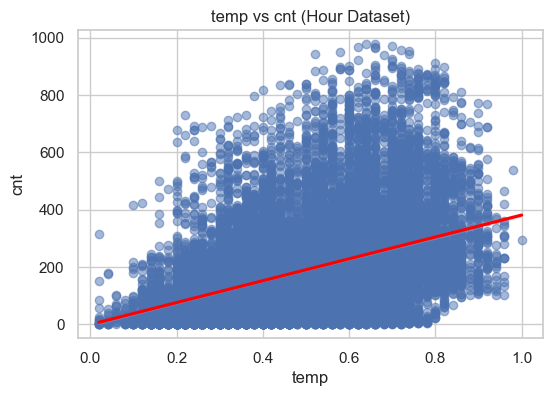

Hour Dataset - Correlation of temp with cnt: 0.40



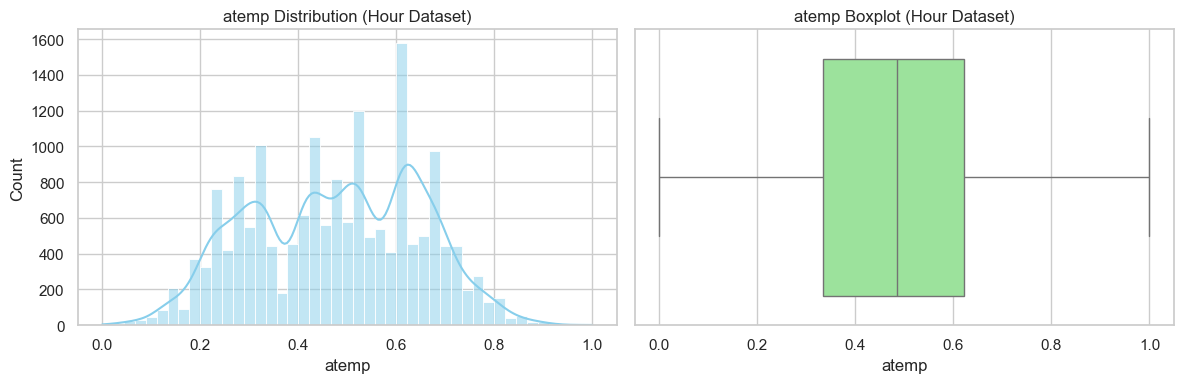

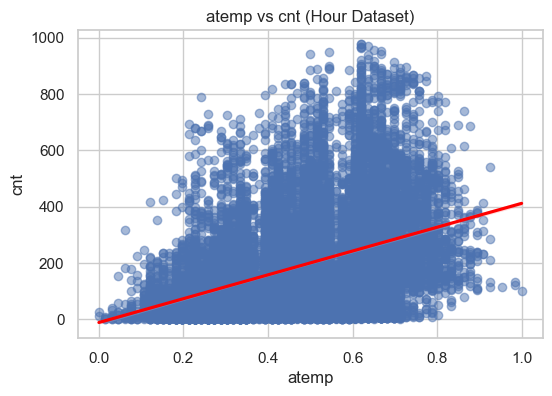

Hour Dataset - Correlation of atemp with cnt: 0.40



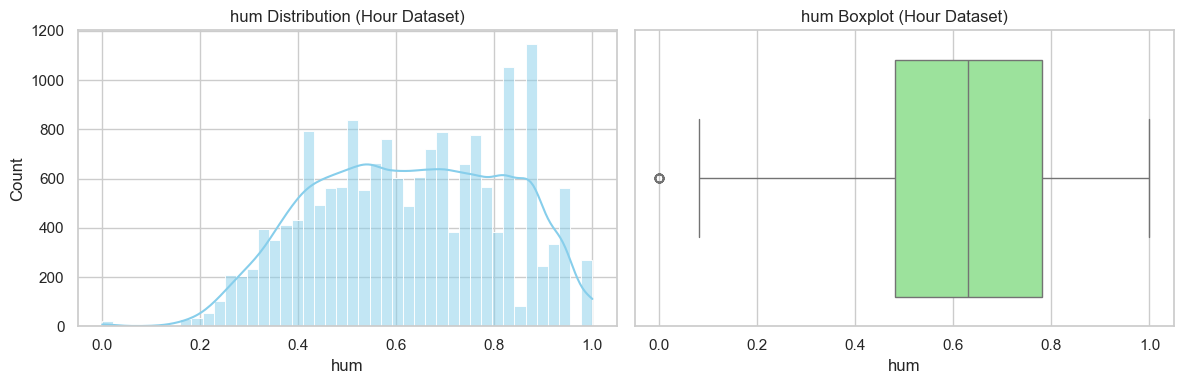

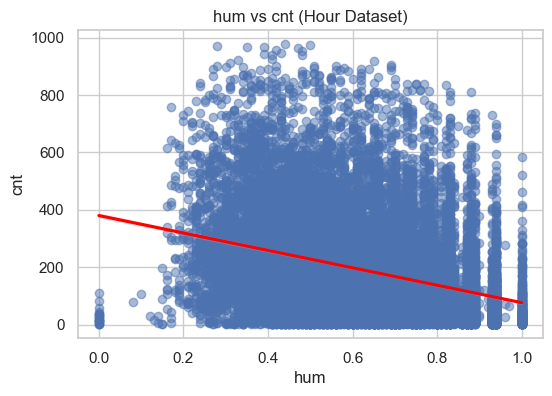

Hour Dataset - Correlation of hum with cnt: -0.32



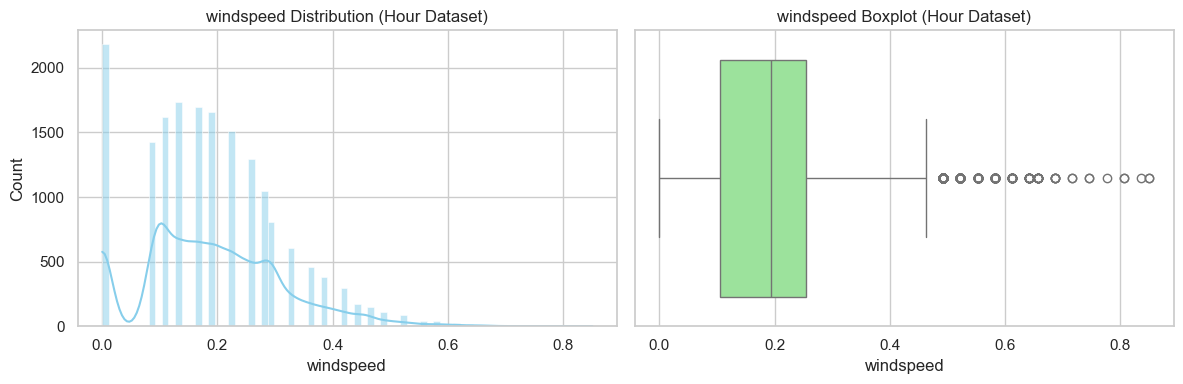

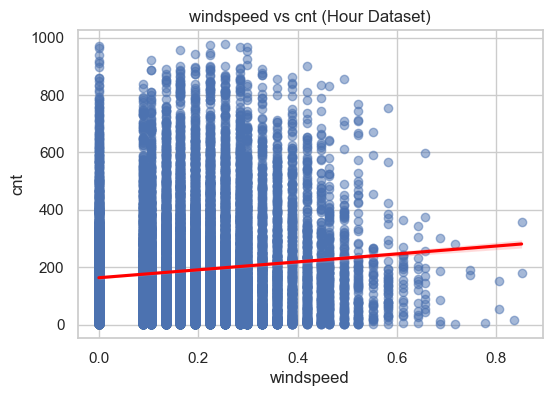

Hour Dataset - Correlation of windspeed with cnt: 0.09



In [6]:

def numeric_analysis(df, dataset_name):
    for col in num_cols:
        plt.figure(figsize=(12,4))
        
        # Histogram 
        plt.subplot(1,2,1)
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'{col} Distribution ({dataset_name})')
        plt.xlabel(col)
        
        # Boxplot
        plt.subplot(1,2,2)
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f'{col} Boxplot ({dataset_name})')
        plt.xlabel(col)
        
        plt.tight_layout()
        plt.show()
        
        # Scatter plot 
        plt.figure(figsize=(6,4))
        sns.regplot(x=col, y='cnt', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.title(f'{col} vs cnt ({dataset_name})')
        plt.xlabel(col)
        plt.ylabel('cnt')
        plt.show()
        
        # Correlation with target
        corr = df[col].corr(df['cnt'])
        print(f"{dataset_name} - Correlation of {col} with cnt: {corr:.2f}\n")

numeric_analysis(day_df, "Day Dataset")
numeric_analysis(hour_df, "Hour Dataset")



In [5]:
# Check skewness of numerical features
num_cols_day = ['temp', 'atemp', 'hum', 'windspeed']
num_cols_hour = ['temp', 'hum', 'windspeed']  # atemp already dropped

def check_skewness(df, num_cols, dataset_name):
    print(f"Skewness for {dataset_name} numerical features:")
    for col in num_cols:
        skew = df[col].skew()
        print(f"{col}: {skew:.2f}")
    print('-'*50)

check_skewness(day_df, num_cols_day, "Day Dataset")
check_skewness(hour_df, num_cols_hour, "Hour Dataset")


Skewness for Day Dataset numerical features:
temp: -0.05
atemp: -0.13
hum: -0.07
windspeed: 0.68
--------------------------------------------------
Skewness for Hour Dataset numerical features:
temp: -0.01
hum: -0.11
windspeed: 0.57
--------------------------------------------------


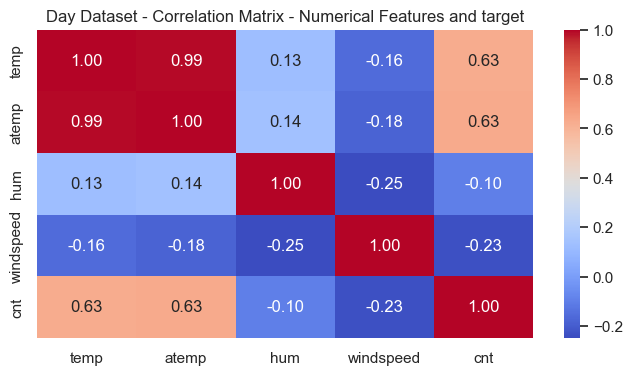

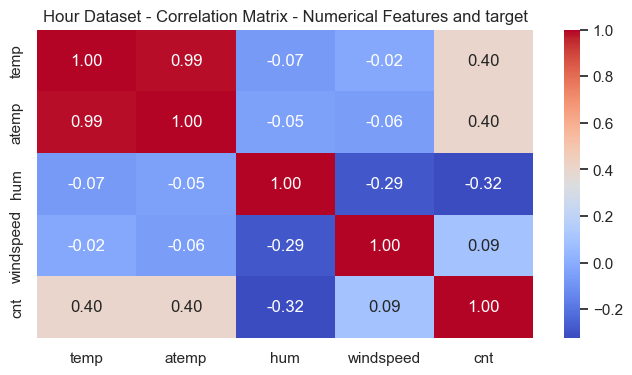

In [6]:
def correlation(df,dataset_name):
    plt.figure(figsize=(8,4))
    corr_matrix=df[num_cols+['cnt']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'{ dataset_name} - Correlation Matrix - Numerical Features and target')
    plt.show()
correlation(day_df,"Day Dataset")
correlation(hour_df,"Hour Dataset")

In [7]:
def calculate_vif(df, features):
    X = df[features]               
    X = sm.add_constant(X) #constant for reg
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(X.values, i+1) for i in range(len(features))]
    
    return vif_data

# day dataset
vif_day = calculate_vif(day_df, num_cols_day)
print("VIF - Day Dataset")
print(vif_day)

# hour dataset
vif_hour = calculate_vif(hour_df, num_cols_hour)
print("VIF - Hour Dataset")
print(vif_hour)

VIF - Day Dataset
     Feature        VIF
0       temp  62.969819
1      atemp  63.632351
2        hum   1.079267
3  windspeed   1.126768
VIF - Hour Dataset
     Feature       VIF
0       temp  1.006988
1        hum  1.098937
2  windspeed  1.094156


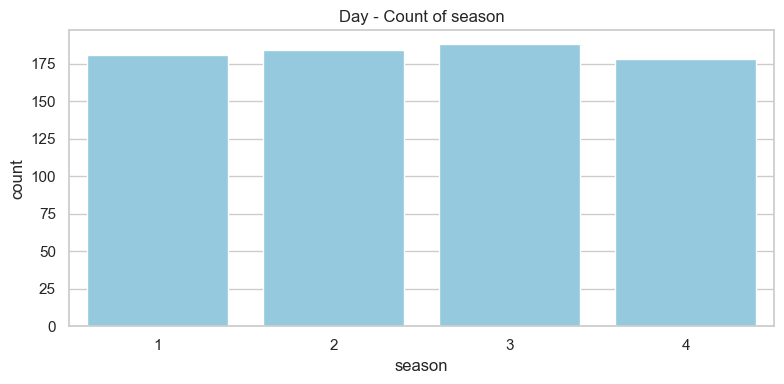

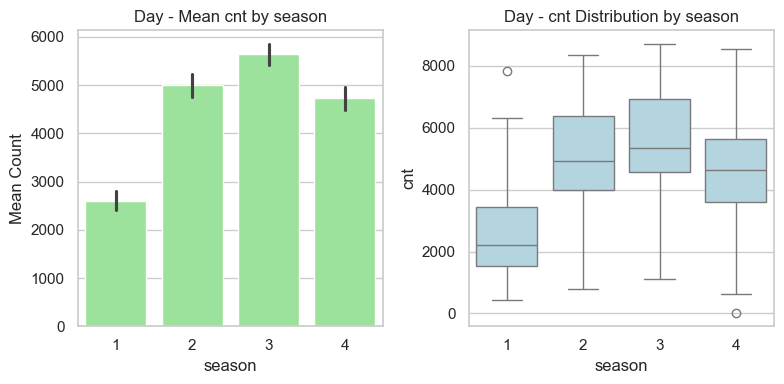

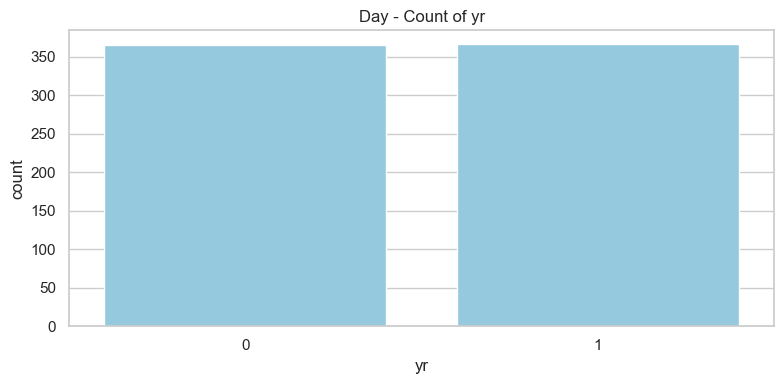

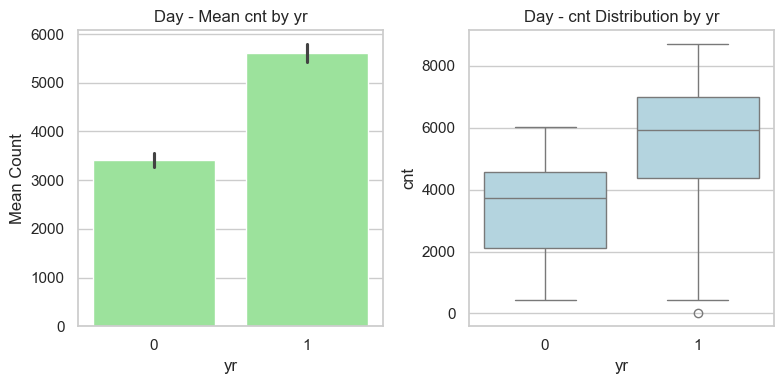

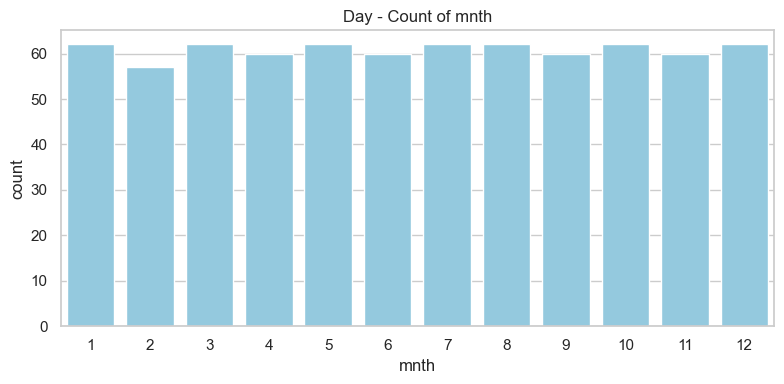

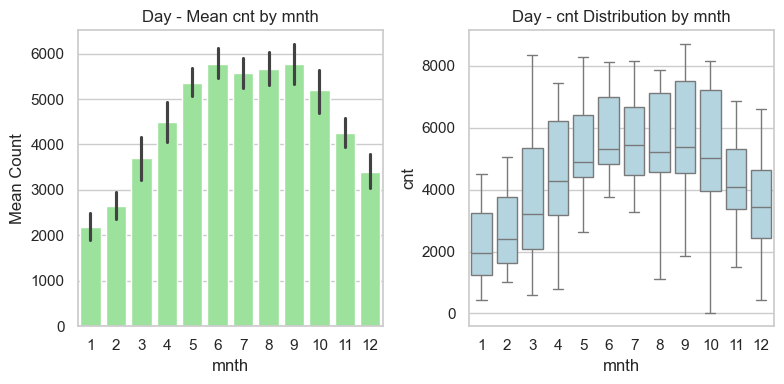

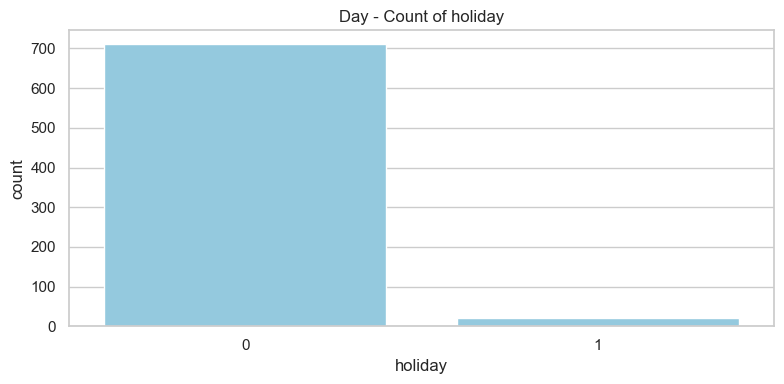

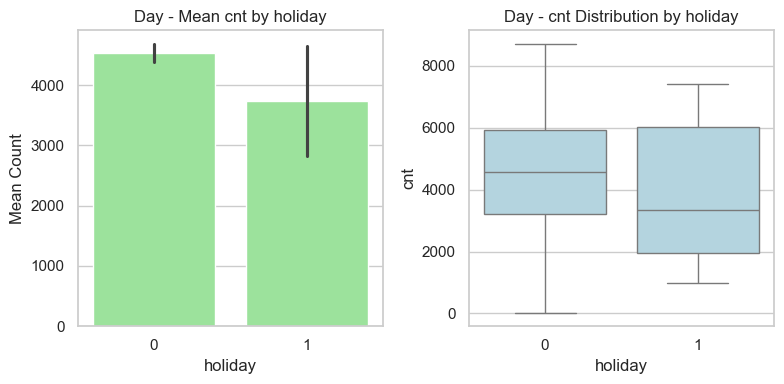

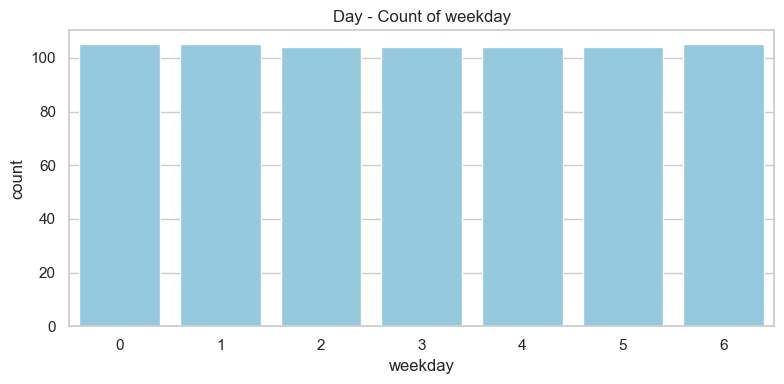

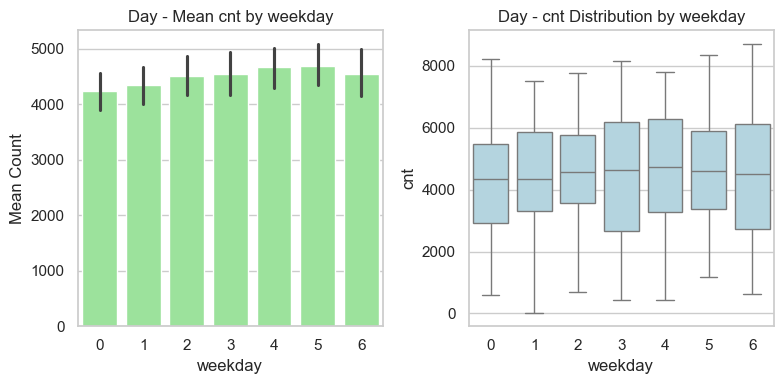

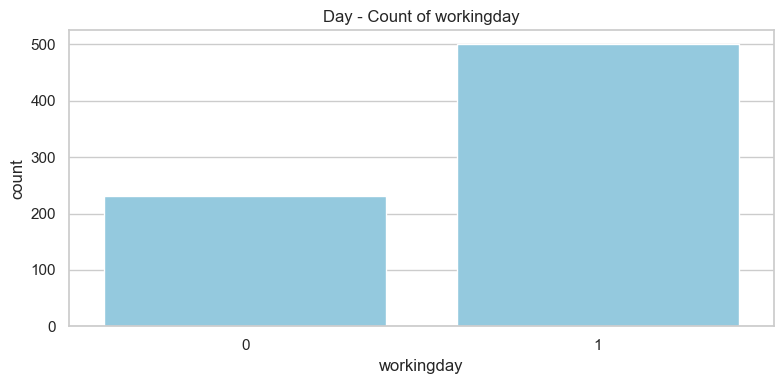

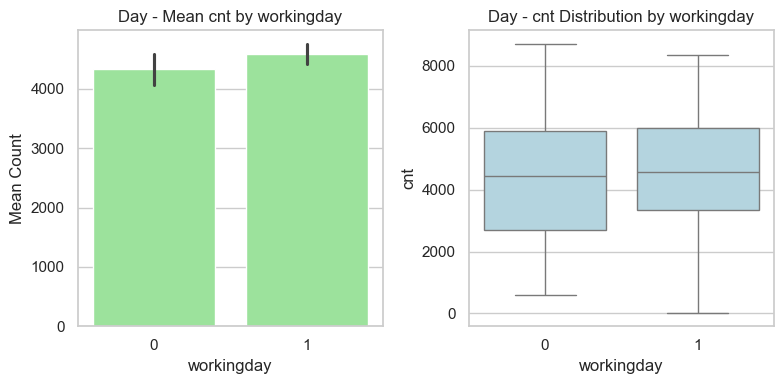

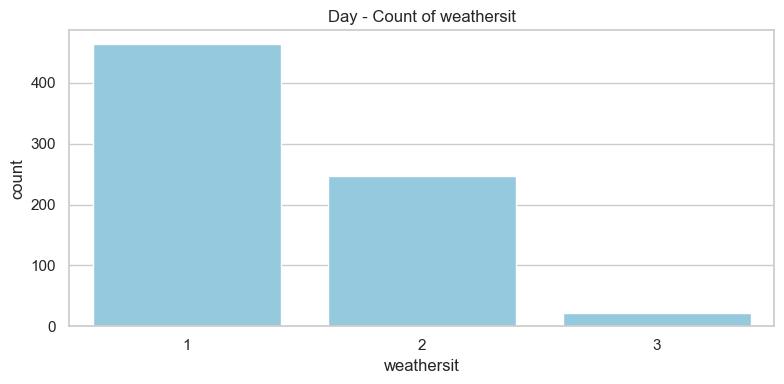

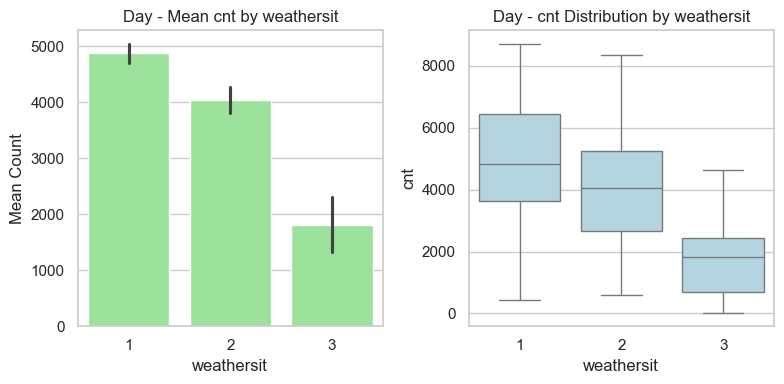

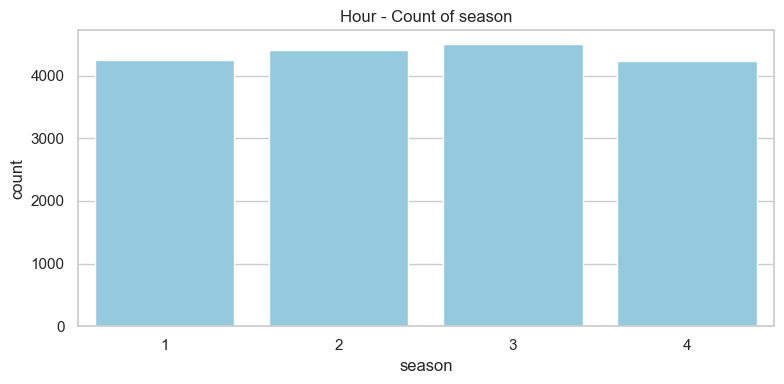

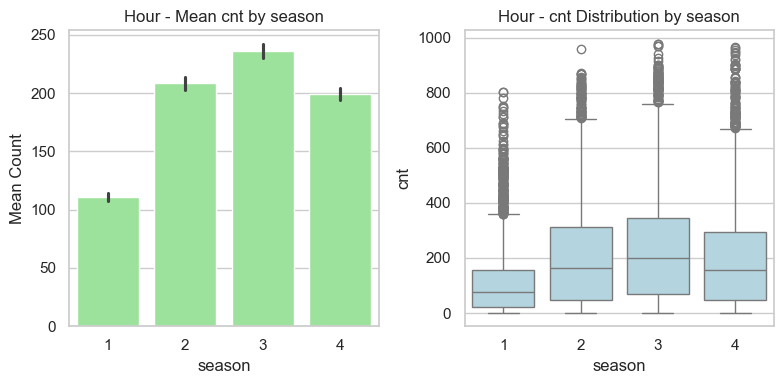

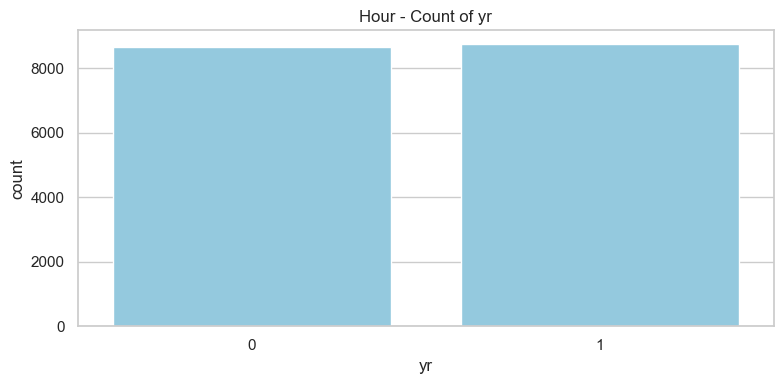

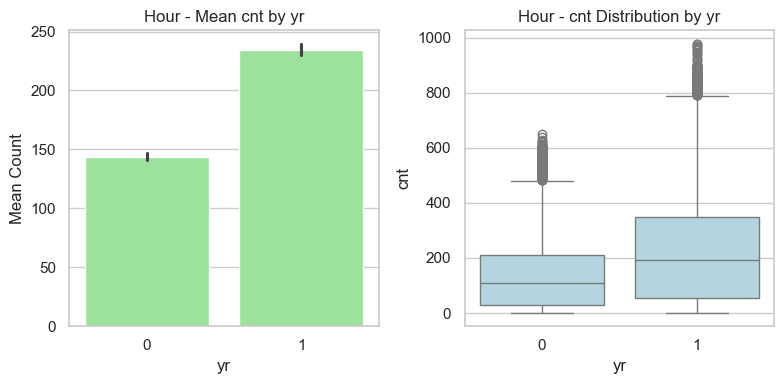

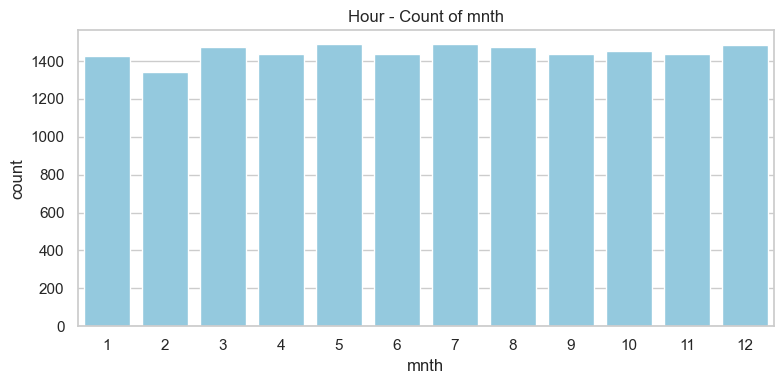

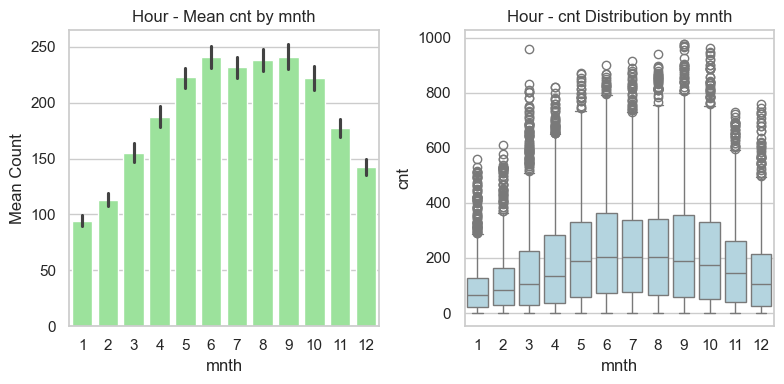

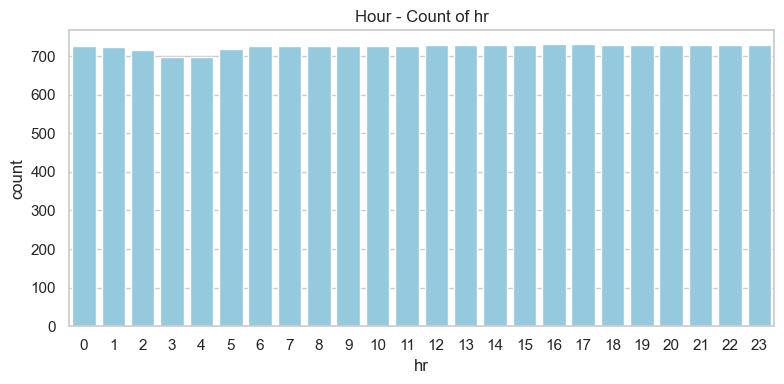

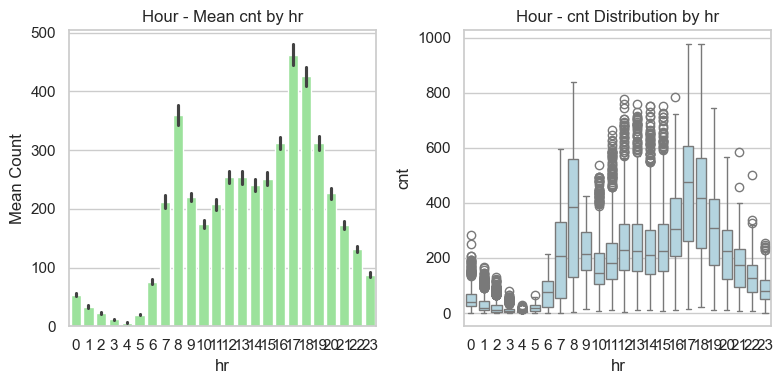

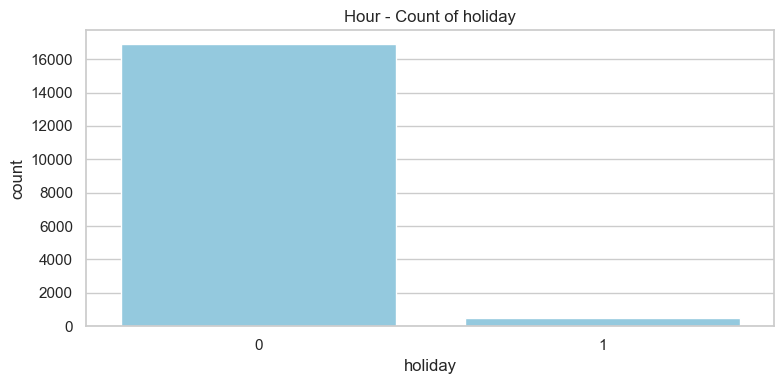

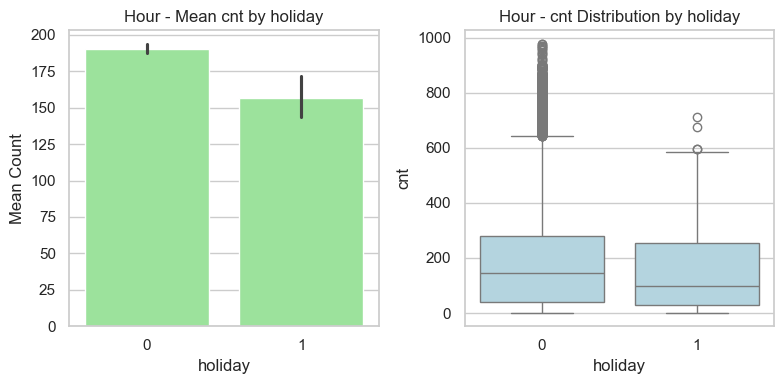

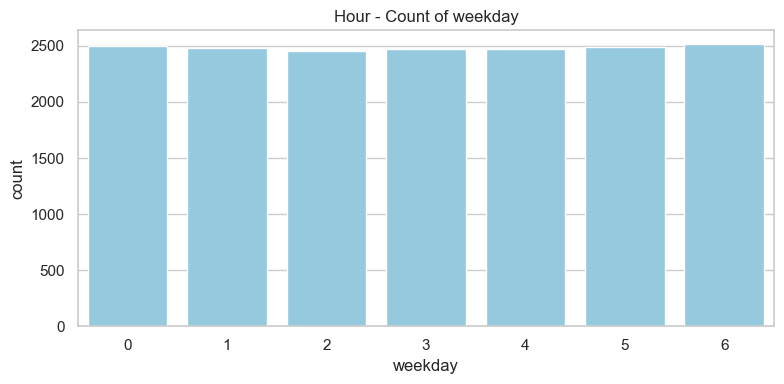

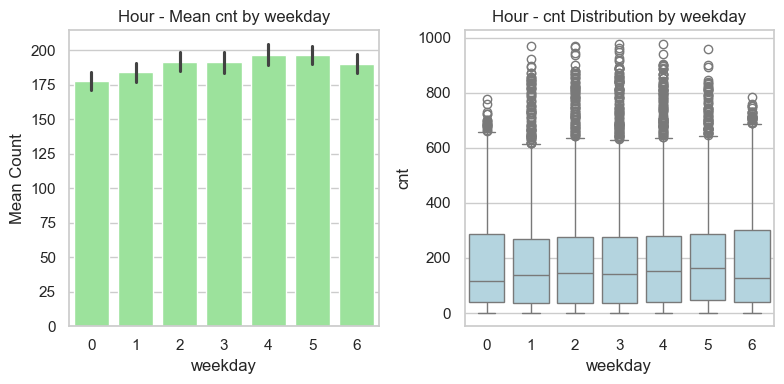

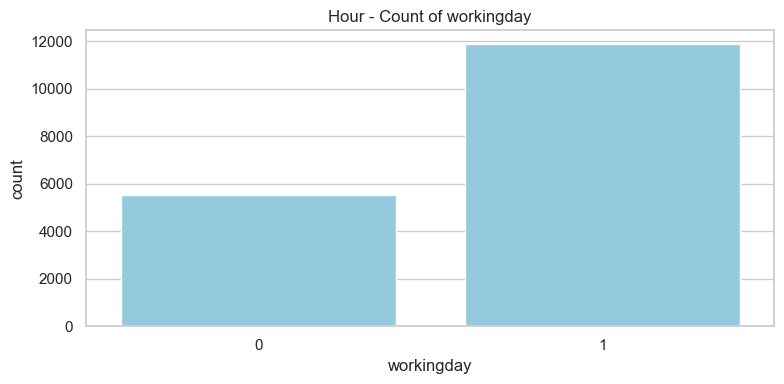

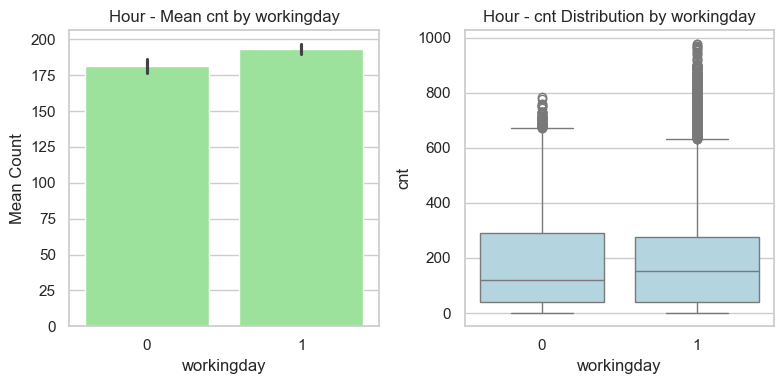

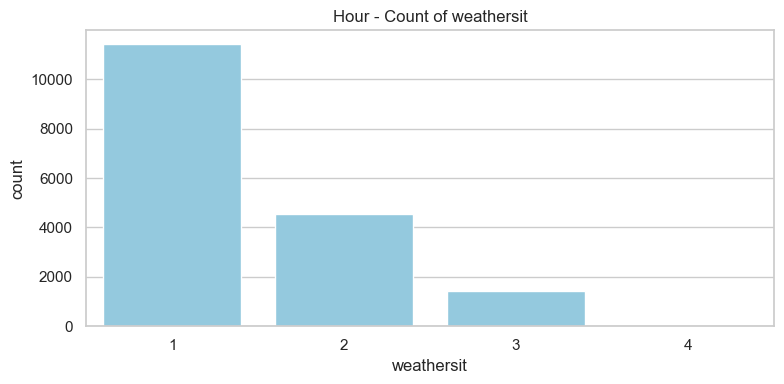

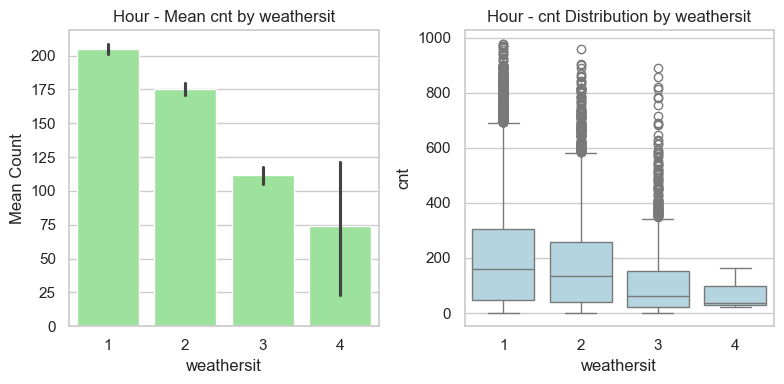


===== Mean cnt Summary for Day Dataset =====

Mean cnt per 'season':
season
1    2604.132597
2    4992.331522
3    5644.303191
4    4728.162921
Name: cnt, dtype: float64
--------------------------------------------------
Mean cnt per 'yr':
yr
0    3405.761644
1    5599.934426
Name: cnt, dtype: float64
--------------------------------------------------
Mean cnt per 'mnth':
mnth
1     2176.338710
2     2655.298246
3     3692.258065
4     4484.900000
5     5349.774194
6     5772.366667
7     5563.677419
8     5664.419355
9     5766.516667
10    5199.225806
11    4247.183333
12    3403.806452
Name: cnt, dtype: float64
--------------------------------------------------
Mean cnt per 'holiday':
holiday
0    4527.104225
1    3735.000000
Name: cnt, dtype: float64
--------------------------------------------------
Mean cnt per 'weekday':
weekday
0    4228.828571
1    4338.123810
2    4510.663462
3    4548.538462
4    4667.259615
5    4690.288462
6    4550.542857
Name: cnt, dtype: float64
------

In [8]:
def cat_analysis(df, cat_cols, dataset_name):
    for col in cat_cols:
        
        # Countplot
        plt.figure(figsize=(8,4))
        sns.countplot(x=col, data=df, color='skyblue')
        plt.title(f'{dataset_name} - Count of {col}')
        plt.tight_layout()
        plt.show()

        
        fig, ax = plt.subplots(1, 2, figsize=(8,4))

        # Barplot 
        sns.barplot(x=col, y='cnt', data=df, color='lightgreen', ax=ax[0])
        ax[0].set_title(f'{dataset_name} - Mean cnt by {col}')
        ax[0].set_xlabel(col)
        ax[0].set_ylabel("Mean Count")

        # Boxplot
        sns.boxplot(x=col, y='cnt', data=df, color='lightblue', ax=ax[1])
        ax[1].set_title(f'{dataset_name} - cnt Distribution by {col}')
        ax[1].set_xlabel(col)
        ax[1].set_ylabel("cnt")

        plt.tight_layout()
        plt.show()
cat_analysis(day_df,cat_cols_day,"Day")
cat_analysis(hour_df,cat_cols_hour,"Hour")

def cat_mean_summary(df, cat_cols, dataset_name):
    print(f"\n===== Mean cnt Summary for {dataset_name} Dataset =====\n")
    for col in cat_cols:
        print(f"Mean cnt per '{col}':")
        print(df.groupby(col, observed=True)['cnt'].mean())
        print('-' * 50)
cat_mean_summary(day_df, cat_cols_day, "Day")
cat_mean_summary(hour_df, cat_cols_hour, "Hour")

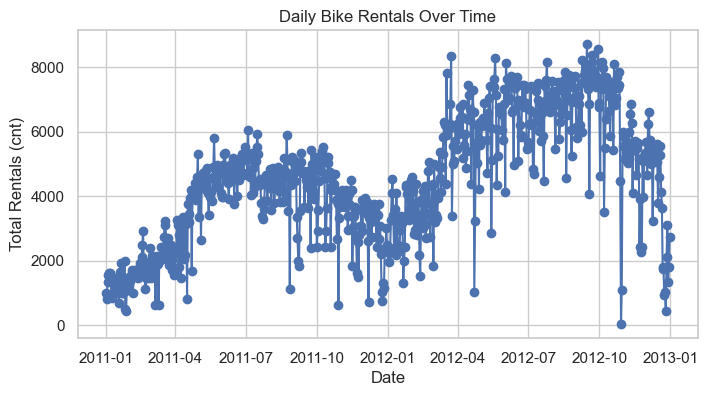

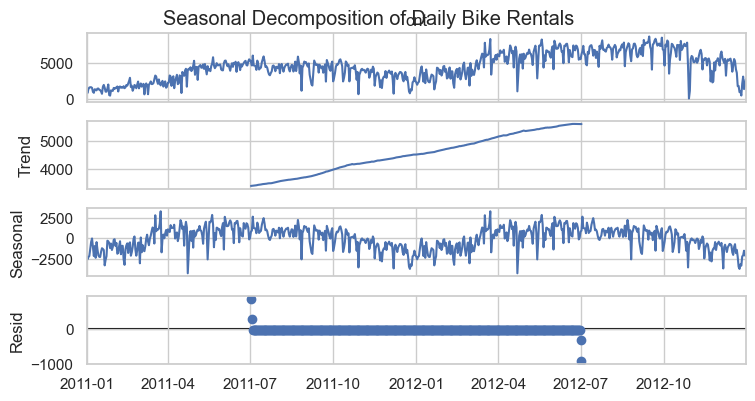

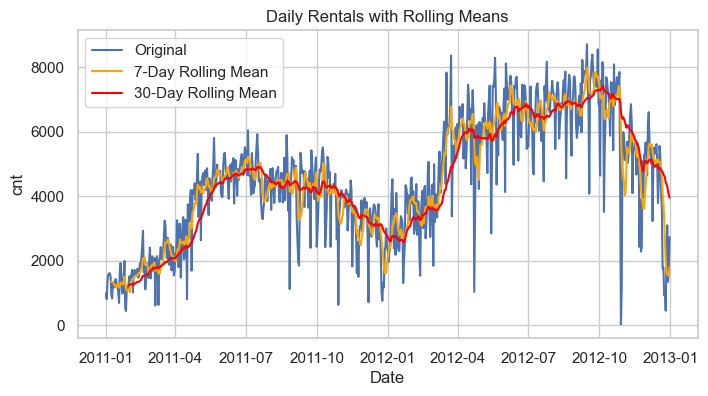

In [11]:
# TIME SERIES ANALYSIS (Daily Rentals) 
# Line plot
plt.figure(figsize=(8,4))
plt.plot(day_df['dteday'], day_df['cnt'], marker='o', linestyle='-')
plt.title("Daily Bike Rentals Over Time")
plt.xlabel("Date")
plt.ylabel("Total Rentals (cnt)")
plt.grid(True)
plt.show()

# Seasonal decomposition
ts = day_df.set_index('dteday')['cnt']
decomposition = seasonal_decompose(ts, model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(8,4)
plt.suptitle("Seasonal Decomposition of Daily Bike Rentals")
plt.show()

# Rolling averages
plt.figure(figsize=(8,4))
plt.plot(ts, label='Original')
plt.plot(ts.rolling(window=7).mean(), label='7-Day Rolling Mean', color='orange')
plt.plot(ts.rolling(window=30).mean(), label='30-Day Rolling Mean', color='red')
plt.title("Daily Rentals with Rolling Means")
plt.xlabel("Date")
plt.ylabel("cnt")
plt.legend()
plt.show()



In [12]:
print(df[num_cols])

       temp   atemp   hum  windspeed
0      0.24  0.2879  0.81     0.0000
1      0.22  0.2727  0.80     0.0000
2      0.22  0.2727  0.80     0.0000
3      0.24  0.2879  0.75     0.0000
4      0.24  0.2879  0.75     0.0000
...     ...     ...   ...        ...
17374  0.26  0.2576  0.60     0.1642
17375  0.26  0.2576  0.60     0.1642
17376  0.26  0.2576  0.60     0.1642
17377  0.26  0.2727  0.56     0.1343
17378  0.26  0.2727  0.65     0.1343

[17379 rows x 4 columns]


In [10]:


def feature_transformation(df, num_cols, dataset_name, target_col='cnt', 
                           target_skew_threshold=0.5, numeric_skew_threshold=0.5):
    """
    Clean feature transformation for numeric features and target.

    Args:
        df: pandas DataFrame
        num_cols: list of numeric columns
        dataset_name: string for logging
        target_col: target variable name
        target_skew_threshold: threshold for target log transform
        numeric_skew_threshold: threshold for numeric log transform

    Returns:
        df: transformed DataFrame
        transformed_cols: list of numeric features ready for modeling
    """
    print(f"--- {dataset_name} Dataset Feature Transformation ---")

    transformed_cols = []

    # --- Target transformation ---
    target_skew = df[target_col].skew()
    if abs(target_skew) > target_skew_threshold:
        df[f'{target_col}_log'] = np.log1p(df[target_col])
        print(f"Target '{target_col}' transformed using log1p (skew={target_skew:.2f})")
    else:
        df[f'{target_col}_log'] = df[target_col]
        print(f"Target '{target_col}' is symmetric (skew={target_skew:.2f}) → no transformation")

    # --- Numeric feature transformation ---
    for col in num_cols:
        if col not in df.columns:
            continue
        skew_val = df[col].skew()
        if abs(skew_val) > numeric_skew_threshold:
            df[f'{col}_log'] = np.log1p(df[col])
            transformed_cols.append(f'{col}_log')
            print(f"Feature '{col}' transformed using log1p (skew={skew_val:.2f})")
        else:
            transformed_cols.append(col)
            print(f"Feature '{col}' is nearly symmetric (skew={skew_val:.2f}) → kept as-is")

    # --- Drop 'atemp' for multicollinearity ---
    if 'atemp' in df.columns:
        df.drop(columns=['atemp'], inplace=True, errors='ignore')
        if 'atemp' in transformed_cols:
            transformed_cols = [col for col in transformed_cols if col != 'atemp']
        if 'atemp_log' in transformed_cols:
            transformed_cols = [col for col in transformed_cols if col != 'atemp_log']
        print("Dropped 'atemp' to handle multicollinearity with 'temp'")

    print(f"--- {dataset_name} Transformation Completed ---\n")
    return df, transformed_cols
num_cols = ['temp', 'atemp', 'hum', 'windspeed']

# Day dataset
day_df_transformed, day_num_cols = feature_transformation(day_df, num_cols.copy(), "Day Dataset")

# Hour dataset
hour_df_transformed, hour_num_cols = feature_transformation(hour_df, num_cols.copy(), "Hour Dataset")

print("Day numeric features:", day_num_cols)
print("Hour numeric features:", hour_num_cols)


--- Day Dataset Dataset Feature Transformation ---
Target 'cnt' is symmetric (skew=-0.05) → no transformation
Feature 'temp' is nearly symmetric (skew=-0.05) → kept as-is
Feature 'atemp' is nearly symmetric (skew=-0.13) → kept as-is
Feature 'hum' is nearly symmetric (skew=-0.07) → kept as-is
Feature 'windspeed' transformed using log1p (skew=0.68)
Dropped 'atemp' to handle multicollinearity with 'temp'
--- Day Dataset Transformation Completed ---

--- Hour Dataset Dataset Feature Transformation ---
Target 'cnt' transformed using log1p (skew=1.28)
Feature 'temp' is nearly symmetric (skew=-0.01) → kept as-is
Feature 'atemp' is nearly symmetric (skew=-0.09) → kept as-is
Feature 'hum' is nearly symmetric (skew=-0.11) → kept as-is
Feature 'windspeed' transformed using log1p (skew=0.57)
Dropped 'atemp' to handle multicollinearity with 'temp'
--- Hour Dataset Transformation Completed ---

Day numeric features: ['temp', 'hum', 'windspeed_log']
Hour numeric features: ['temp', 'hum', 'windspeed_l

In [11]:
print(hour_df_transformed.columns)
hour_df_transformed['hr'].dtype


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'cnt_log', 'windspeed_log'],
      dtype='object')


CategoricalDtype(categories=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                  15, 16, 17, 18, 19, 20, 21, 22, 23],
, ordered=False, categories_dtype=int64)

In [12]:
def datetime_feature_engineering(df, dataset_name):
    
    # Day features
    if 'dteday' in df.columns:
        df['year'] = df['dteday'].dt.year
        df['month'] = df['dteday'].dt.month
        df['weekday'] = df['dteday'].dt.weekday
        df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

        # Cyclical encoding for months
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Hour features
    if 'hr' in df.columns:
        df['hr'] = df['hr'].astype(int)
        df['is_peak_hour'] = df['hr'].isin([7,8,9,17,18,19]).astype(int)
        df['hour_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hr'] / 24)

    print(f"Datetime features added for {dataset_name} dataset.")
    return df
day_df_transformed = datetime_feature_engineering(day_df_transformed, "Day")
hour_df_transformed = datetime_feature_engineering(hour_df_transformed, "Hour")

Datetime features added for Day dataset.
Datetime features added for Hour dataset.


In [16]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'cnt_log', 'windspeed_log', 'year', 'month',
       'is_weekend', 'month_sin', 'month_cos', 'is_peak_hour', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [13]:
def engineered_features(df, dataset_name):

    # Ensure workingday is numeric
    if 'workingday' in df.columns:
        df['workingday'] = df['workingday'].astype(int)

    # Interaction: temp × windspeed
    df['temp_wind'] = df['temp'] * df['windspeed']

    # Season × workingday (summer = season 3)
    df['summer_workingday'] = ((df['season'] == 3) & (df['workingday'] == 1)).astype(int)

    print(f"Engineered features added for {dataset_name} dataset.")
    return df



day_df_transformed = engineered_features(day_df_transformed, "Day")



# ---- CORRELATION WITH TARGET -----

print("\nTop correlations for Day dataset:")
print(day_df_transformed.corr()['cnt'].sort_values(ascending=False).head(15))



Engineered features added for Day dataset.

Top correlations for Day dataset:
cnt_log              1.000000
cnt                  1.000000
registered           0.945517
casual               0.672804
instant              0.628830
dteday               0.628830
temp                 0.627494
year                 0.566710
yr                   0.566710
season               0.406100
summer_workingday    0.292965
temp_wind            0.286312
mnth                 0.279977
month                0.279977
workingday           0.061156
Name: cnt, dtype: float64


In [53]:
df.columns



Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'cnt_log', 'windspeed_log', 'year', 'month',
       'is_weekend', 'month_sin', 'month_cos', 'is_peak_hour', 'hour_sin',
       'hour_cos', 'temp_wind', 'summer_workingday', 'peak_workingday'],
      dtype='object')

In [14]:
day_df_transformed.head()
day_df_transformed.columns

# Show columns and their data types
print(day_df_transformed.dtypes)


instant                       int64
dteday               datetime64[ns]
season                     category
yr                         category
mnth                       category
holiday                    category
weekday                       int32
workingday                    int64
weathersit                 category
temp                        float64
hum                         float64
windspeed                   float64
casual                        int64
registered                    int64
cnt                           int64
cnt_log                       int64
windspeed_log               float64
year                          int32
month                         int32
is_weekend                    int64
month_sin                   float64
month_cos                   float64
temp_wind                   float64
summer_workingday             int64
dtype: object


In [15]:
drop_cols = ['instant', 'dteday', 'casual', 'registered', 'cnt', 'cnt_log','yr','mnth']

X = day_df_transformed.drop(columns=drop_cols)
y = day_df_transformed['cnt']


In [16]:
#  Time-series train-test split
split_index = int(len(X) * 0.8)  # 80% train, 20% test

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

cat_cols_day = ['season','holiday','weekday','workingday','weathersit','is_weekend']
for col in cat_cols_day:
    X_train[col] = X_train[col].astype('int')
    X_test[col] = X_test[col].astype('int')

num_cols_final = [c for c in X_train.columns if c not in cat_cols_day]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols_final] = scaler.fit_transform(X_train[num_cols_final])
X_test_scaled[num_cols_final]  = scaler.transform(X_test[num_cols_final])


In [17]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    return r2, mse, rmse, mae


results = pd.DataFrame(columns=['Model', 'R2', 'MSE', 'RMSE', 'MAE'])


def add_result(name, r2, mse, rmse, mae):
    global results
    if name in results['Model'].values:
        return
    results.loc[len(results)] = [name, r2, mse, rmse, mae]


In [18]:
# Linear Regression
lr = LinearRegression()
r2, mse, rmse, mae = evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test)
add_result("Linear Regression", r2, mse, rmse, mae)

# Ridge Regression 
ridge = Ridge(alpha=1.0)
r2, mse, rmse, mae = evaluate_model(ridge, X_train_scaled, y_train, X_test_scaled, y_test)
add_result("Ridge Regression", r2, mse, rmse, mae)

# Lasso Regression
lasso = Lasso(alpha=0.01,max_iter=10000)
r2, mse, rmse, mae = evaluate_model(lasso, X_train_scaled, y_train, X_test_scaled, y_test)
add_result("Lasso Regression", r2, mse, rmse, mae)

# Elastinet
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
r2, mse, rmse, mae = evaluate_model(elastic, X_train_scaled, y_train, X_test_scaled, y_test)
add_result("ElasticNet", r2, mse, rmse, mae)

# Random Forest 
rf = RandomForestRegressor(
    n_estimators=300,random_state=42,max_depth=None,min_samples_split=2,
    min_samples_leaf=1,n_jobs=-1
)

r2, mse, rmse, mae = evaluate_model(rf, X_train, y_train, X_test, y_test)
add_result("Random Forest", r2, mse, rmse, mae)

# Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.1, random_state=42)
r2, mse, rmse, mae = evaluate_model(gbr, X_train, y_train, X_test, y_test)
add_result("Gradient Boosting", r2, mse, rmse, mae)

# XGBoost 
xgb = XGBRegressor(
    n_estimators=300,learning_rate=0.1,max_depth=4,subsample=0.8,
    colsample_bytree=0.8,random_state=42,n_jobs=-1)
r2, mse, rmse, mae = evaluate_model(xgb, X_train, y_train, X_test, y_test)
add_result("XGBoost", r2, mse, rmse, mae)

#CatBoost
cat = CatBoostRegressor(
    iterations=300,learning_rate=0.1,depth=4,
    random_state=42,verbose=0
)

r2, mse, rmse, mae = evaluate_model(cat, X_train, y_train, X_test, y_test)
add_result("CatBoost", r2, mse, rmse, mae)


# Define base models
estimators = [
    ('rf', RandomForestRegressor(
        n_estimators=300, random_state=42, max_depth=None,
        min_samples_split=2, min_samples_leaf=1, n_jobs=-1)),
    
    ('gbr', GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.1, random_state=42)),
    
    ('cat', CatBoostRegressor(
        iterations=300, learning_rate=0.1, depth=4,
        random_state=42, verbose=0))
]

# Create stacking regressor
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

# Evaluate
r2, mse, rmse, mae = evaluate_model(stack, X_train, y_train, X_test, y_test)
add_result("Stacking Regressor", r2, mse, rmse, mae)

print("Stacking Regressor Results:")
print("R2:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)


results = results.sort_values(by='R2', ascending=False).reset_index(drop=True)
results

Stacking Regressor Results:
R2: 0.7670552334259022
MSE: 818614.6686951095
RMSE: 904.7732692200348
MAE: 718.8957169373422


,Model,R2,MSE,RMSE,MAE
0,Stacking Regressor,0.767055,8.186147e+05,904.773269,718.895717
1,XGBoost,0.750798,8.757469e+05,935.813516,725.195496
2,Gradient Boosting,0.743503,9.013825e+05,949.411684,767.731872
3,CatBoost,0.702638,1.044991e+06,1022.248116,831.331845
4,Random Forest,0.646263,1.243103e+06,1114.945429,915.324150
5,Ridge Regression,0.534890,1.634489e+06,1278.471213,994.395435
6,ElasticNet,0.534475,1.635947e+06,1279.041307,995.555849
7,Lasso Regression,0.532324,1.643507e+06,1281.993459,996.088015
8,Linear Regression,0.532247,1.643778e+06,1282.099165,996.166802


In [21]:
print(y_train.max(), y_train.min())
print(y_test.max(), y_test.min())


8362 431
8714 22


In [21]:
from sklearn.model_selection import GridSearchCV
#Catboost
cat = CatBoostRegressor(
        iterations=300, learning_rate=0.1, depth=4,
        random_state=42, verbose=0)
param_grid_cat = {
    'iterations': [300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_cat = GridSearchCV(cat, param_grid_cat, cv=3, scoring='r2', n_jobs=-1)
grid_cat.fit(X_train_scaled, y_train)

print("Best CatBoost Parameters:", grid_cat.best_params_)
print("Best CatBoost CV R2:", grid_cat.best_score_)

# Evaluate on test set
r2_cat, mse_cat, rmse_cat, mae_cat = evaluate_model(grid_cat.best_estimator_, 
                                                   X_train_scaled, y_train, 
                                                   X_test_scaled, y_test)
add_result("CatBoost Tuned", r2_cat, mse_cat, rmse_cat, mae_cat)
best_cat = grid_cat.best_estimator_
print("CatBoost Tuned Results - R2:", r2_cat, "MSE:",mse_cat,"RMSE:", rmse_cat, "MAE:", mae_cat)

# --- Hyperparameter Grid for Gradient Boosting ---
gbr = GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.1, random_state=42)
param_grid_gbr = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

grid_gbr = GridSearchCV(gbr, param_grid_gbr, cv=3, scoring='r2', n_jobs=-1)
grid_gbr.fit(X_train_scaled, y_train)

print("Best GBR Parameters:", grid_gbr.best_params_)
print("Best GBR CV R2:", grid_gbr.best_score_)

# Evaluate on test set
r2_gbr, mse_gbr, rmse_gbr, mae_gbr = evaluate_model(grid_gbr.best_estimator_, 
                                                   X_train_scaled, y_train, 
                                                   X_test_scaled, y_test)
add_result("Gradient Boosting Tuned", r2_gbr, mse_gbr, rmse_gbr, mae_gbr)
best_gbr = grid_gbr.best_estimator_
print("Gradient Boosting Tuned Results - R2:", r2_gbr,"MSE:",mse_gbr, "RMSE:", rmse_gbr, "MAE:", mae_gbr)

#Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid_rf = {
    'n_estimators': [300, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF Parameters:", grid_rf.best_params_)
print("Best RF CV R2:", grid_rf.best_score_)

r2_rf, mse_rf, rmse_rf, mae_rf = evaluate_model(
    grid_rf.best_estimator_, X_train, y_train, X_test, y_test)
add_result("Random Forest Tuned", r2_rf, mse_rf, rmse_rf, mae_rf)
best_rf  = grid_rf.best_estimator_
print("Random Forest Tuned Results - R2:", r2_rf,"MSE:",mse_rf, "RMSE:", rmse_rf, "MAE:", mae_rf)


estimators = [
    ('rf', best_rf),
    ('gbr', best_gbr),
    ('cat', best_cat)
]
stack_final = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)
stack_final.fit(X_train, y_train)

y_pred_final = stack_final.predict(X_test)
r2_final = r2_score(y_test, y_pred_final)
mse_final=mean_squared_error(y_test,y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)
add_result("Stacking Regressor (Final)", r2_final, mse_final, rmse_final, mae_final)

print("Stacking Regressor Results (Original-scale):")
print("R2:", r2_final,"MSE:",mse_final, "RMSE:", rmse_final, "MAE:", mae_final)

# --- Sort results by R2 ---
results = results.sort_values(by='R2', ascending=False).reset_index(drop=True)
results




Best CatBoost Parameters: {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Best CatBoost CV R2: 0.3422215052054535
CatBoost Tuned Results - R2: 0.7382745859221669 MSE: 919755.641156522 RMSE: 959.0389153504262 MAE: 770.7536496309489
Best GBR Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 500}
Best GBR CV R2: 0.2818835703036901
Gradient Boosting Tuned Results - R2: 0.7428409857931986 MSE: 903708.3953972368 RMSE: 950.6357848288885 MAE: 760.5395697059931
Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best RF CV R2: -0.14084535623535518
Random Forest Tuned Results - R2: 0.45426860351113907 MSE: 1917809.67180966 RMSE: 1384.8500539082418 MAE: 1195.6294013605443
Stacking Regressor Results (Original-scale):
R2: 0.7900207874020277 MSE: 737909.1021522115 RMSE: 859.0163573251742 MAE: 655.0461373286012


,Model,R2,MSE,RMSE,MAE
0,Stacking Regressor (Final),0.790021,7.379091e+05,859.016357,655.046137
1,Stacking Regressor,0.767055,8.186147e+05,904.773269,718.895717
2,XGBoost,0.750798,8.757469e+05,935.813516,725.195496
3,Gradient Boosting,0.743503,9.013825e+05,949.411684,767.731872
4,Gradient Boosting Tuned,0.742841,9.037084e+05,950.635785,760.539570
5,CatBoost Tuned,0.738275,9.197556e+05,959.038915,770.753650
6,CatBoost,0.702638,1.044991e+06,1022.248116,831.331845
7,Random Forest,0.646263,1.243103e+06,1114.945429,915.324150
8,Ridge Regression,0.534890,1.634489e+06,1278.471213,994.395435
9,ElasticNet,0.534475,1.635947e+06,1279.041307,995.555849


In [22]:
results

,Model,R2,MSE,RMSE,MAE
0,Stacking Regressor (Final),0.790021,7.379091e+05,859.016357,655.046137
1,Stacking Regressor,0.767055,8.186147e+05,904.773269,718.895717
2,XGBoost,0.750798,8.757469e+05,935.813516,725.195496
3,Gradient Boosting,0.743503,9.013825e+05,949.411684,767.731872
4,Gradient Boosting Tuned,0.742841,9.037084e+05,950.635785,760.539570
5,CatBoost Tuned,0.738275,9.197556e+05,959.038915,770.753650
6,CatBoost,0.702638,1.044991e+06,1022.248116,831.331845
7,Random Forest,0.646263,1.243103e+06,1114.945429,915.324150
8,Ridge Regression,0.534890,1.634489e+06,1278.471213,994.395435
9,ElasticNet,0.534475,1.635947e+06,1279.041307,995.555849


In [32]:
X_train.columns

Index(['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'hum', 'windspeed', 'windspeed_log', 'year', 'month', 'is_weekend',
       'month_sin', 'month_cos', 'temp_wind', 'summer_workingday'],
      dtype='object')

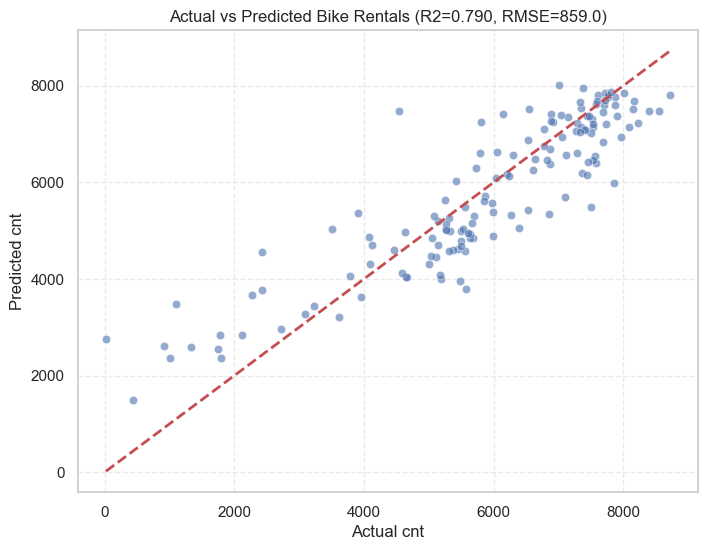

In [23]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.title(f"Actual vs Predicted Bike Rentals (R2={r2_final:.3f}, RMSE={rmse_final:.1f})")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


=== SHAP Analysis: GradientBoosting (Tuned) ===


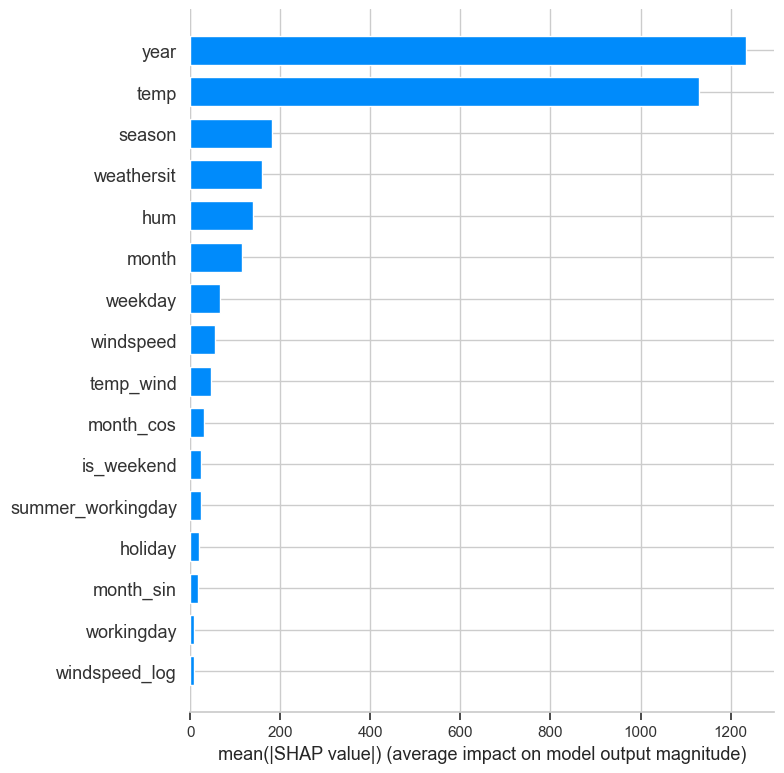


=== SHAP Analysis: RandomForest (Tuned) ===


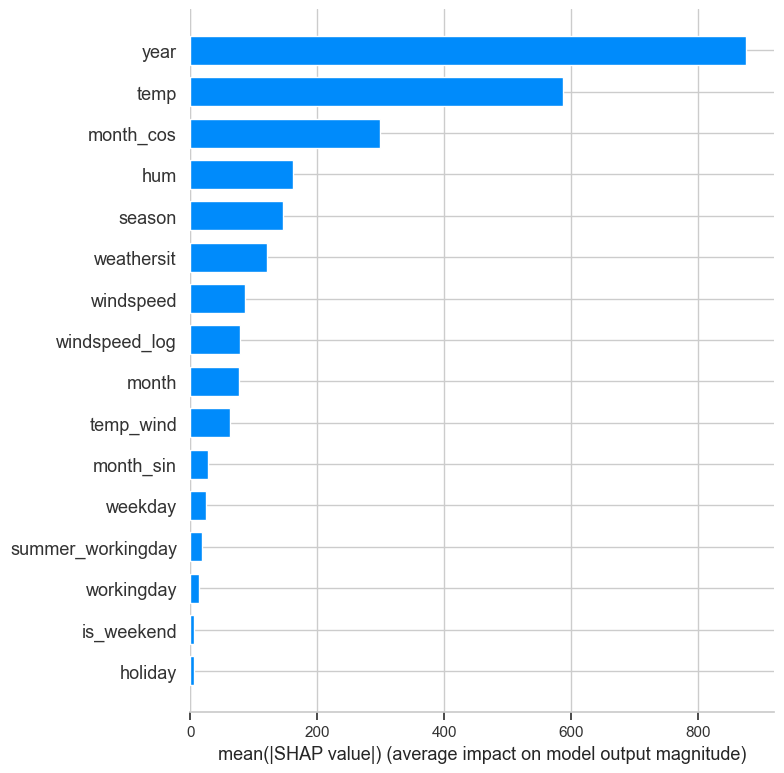


=== SHAP Analysis: CatBoost (Tuned) ===


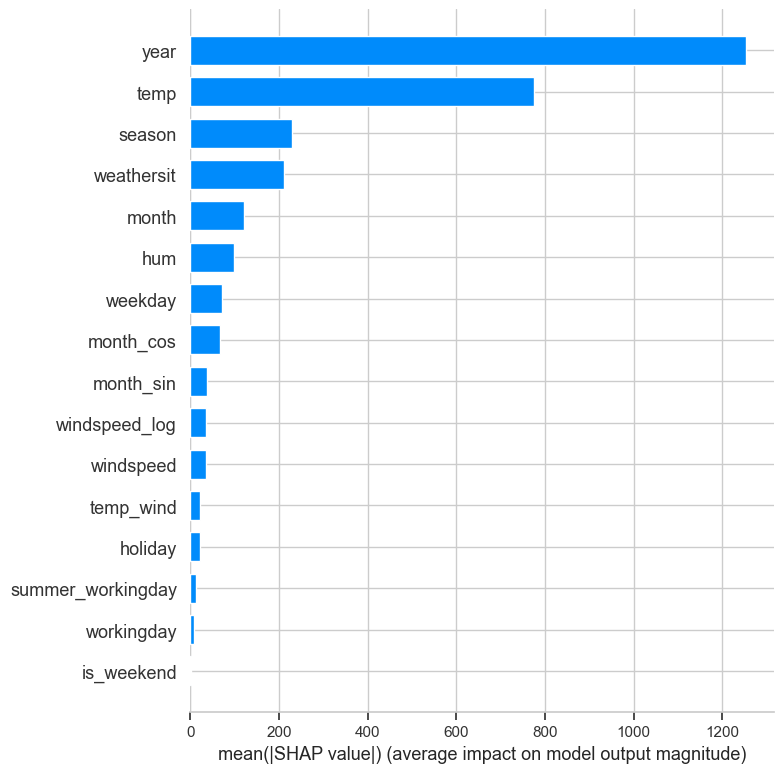

In [24]:
import shap

# Define models to explain
models_to_explain = {
    "GradientBoosting (Tuned)": best_gbr,
    "RandomForest (Tuned)": best_rf,
    "CatBoost (Tuned)": best_cat
}

# Make sure X_test is the correct version for each model
X_shap = X_test.copy()  # Tree models can work with original scale for now

for name, model in models_to_explain.items():
    print(f"\n=== SHAP Analysis: {name} ===")
    
    # Use TreeExplainer (works for RF, GB, CatBoost)
    explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(X_shap)
    
    # Summary plot
    shap.summary_plot(shap_values, X_shap, plot_type="bar", show=True)




In [27]:
# Random Forest
best_rf.fit(X_train, y_train)
rf_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'RandomForest': best_rf.feature_importances_
})

# Gradient Boosting
best_gbr.fit(X_train, y_train)
gbr_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'GradientBoosting': best_gbr.feature_importances_
})


# CatBoost
best_cat.fit(X_train, y_train)
cat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'CatBoost': best_cat.get_feature_importance()
})
cat_imp['CatBoost'] = cat_imp['CatBoost'] / cat_imp['CatBoost'].sum()

# Merge all importance DataFrames correctly
feature_imp = (
    rf_imp
    .merge(gbr_imp, on='Feature')
    .merge(cat_imp, on='Feature')
)

# Mean importance across all models
feature_imp['Average'] = feature_imp[
    ['RandomForest', 'GradientBoosting',  'CatBoost']
].mean(axis=1)

# Sort by average importance
feature_imp = feature_imp.sort_values(by='Average', ascending=False)


feature_imp

top_features = feature_imp['Feature'].head(10).tolist()
print("Top features based on average importance:")
print(top_features)

Top features based on average importance:
['temp', 'year', 'season', 'hum', 'month_cos', 'weathersit', 'month', 'temp_wind', 'windspeed', 'windspeed_log']


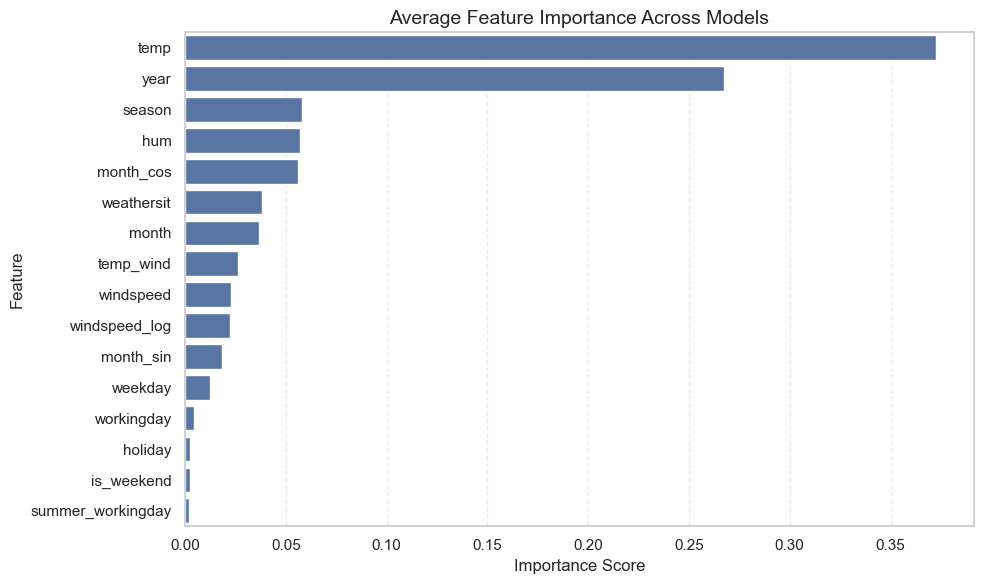

In [28]:
plot = feature_imp.sort_values(by='Average', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot,
    x='Average',
    y='Feature'
)

plt.title("Average Feature Importance Across Models", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


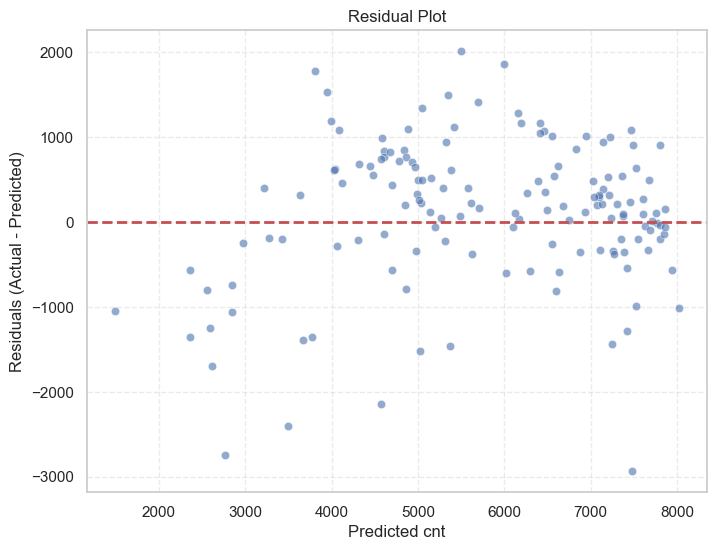

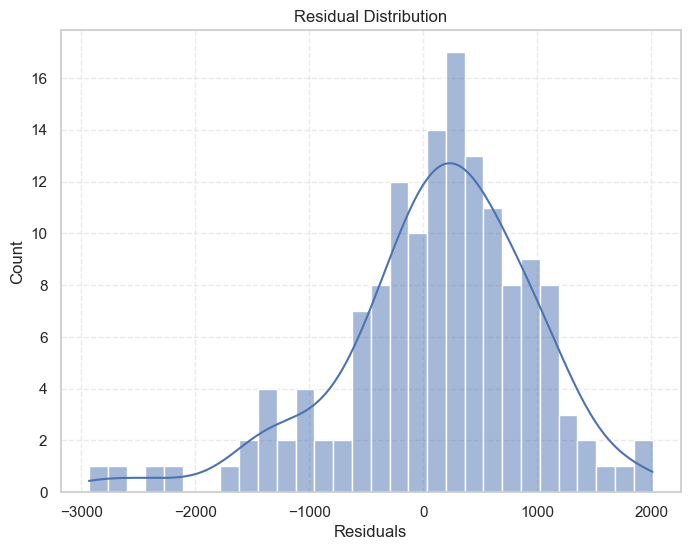

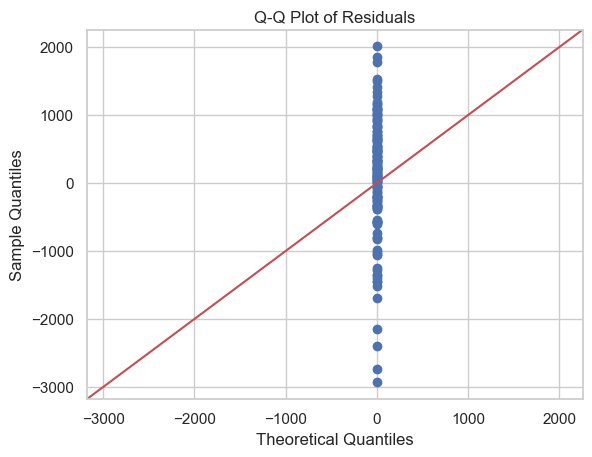

In [29]:
residuals = y_test - y_pred_final

#Scatter of residuals
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Predicted cnt")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Histogram + KDE of residuals 
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Q-Q plot of residuals
sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()



In [31]:

os.makedirs("model", exist_ok=True)

# Save models into the folder
joblib.dump(stack_final, 'model/final_bike_model.pkl')
joblib.dump(top_features, 'model/top_features_avg.joblib')
joblib.dump(scaler, 'model/scaler.pkl')


['model/scaler.pkl']